In [131]:
import pickle, os, sys, math
import numpy as np
import pandas as pd
import seaborn as sns
from numpy import random
import matplotlib.pyplot as plt

PROJECT_DIR = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.insert(1, PROJECT_DIR)

from samples.data_sim import remove_feature
from city_pv_uni_modal import CityPV_UniModal
from city_pv_multi_modal import CityPV_MultiModal
from feature_selection import tune_pacf, rfecv_selection
from utils_pv import get_available_modules, get_available_inverters, visualize_pv, visualize_env, adj_r2_scorer
from samples.data_sim import PVDataset

random_seed = 3
random.seed(random_seed)
np.random.seed(random_seed)
random_state = np.random.RandomState(random_seed)


## Loading the Data
Data generated in samples/PV_generation/2_feature_engineering.ipynb
 
### Train-Test Split
* only in June and July
* different training scenarios using 2 weeks, 1 year, 5 years, and 14 years of data between 2005-2018 for training
* always test on June and July of 2019 (non-overlapping with the training set)


In [132]:
# Name of the experiment
exp_name = 'PV_UniModal'

def open_experiment(exp_name):
    filename_env = os.getcwd() + '/../../saved_results/' + exp_name + '_env' 
    file = open(filename_env + '_feat_eng', 'rb')
    env_dict = pickle.load(file)
    file.close()
    return env_dict

env_dict = open_experiment(exp_name)


#msg = '[INFO] loaded data for {:2.0f} clients'.format(env_dict['num_clients']) no need to store msg in a variable
#print('\n'+env_dict['info'])
print(f"[INFO] loaded data for {env_dict['num_clients']:2.0f} clients' \n\n{env_dict['info']}")

for scenario_name in env_dict['train_scenarios'].keys():
    print(scenario_name + ' has {:3.0f} train and {:3.0f} validation samples'.format(
                    env_dict['train_scenarios'][scenario_name]['clients_data'][0][0].shape[0],
                    env_dict['train_scenarios'][scenario_name]['clients_data'][0][2].shape[0]))
print('number of features = {:2.0f}'.format(
                    env_dict['train_scenarios'][scenario_name]['clients_data'][0][0].shape[1]))


[INFO] loaded data for 24 clients' 

24 households at Lausanne - tilt_std: 5.0, az_std: 15.0, weather_dev: 0.1, irrad_std: 0.2, altitude_dev: 0.1, shadow_peak_red: 0.8, different module_name, different inverter_name, 
sml has 150 train and 610 validation samples
1y has 610 train and 610 validation samples
5y has 3050 train and 610 validation samples
14y has 8540 train and 610 validation samples
number of features = 22


In [133]:
#Understanding the data and the features
print(f"The data has the following fields {env_dict.keys()}")
print(f"city name {env_dict['city_names']}")
print(f"number of clients {env_dict['num_clients']}, or number of buildings ")
print(f"number of modes {env_dict['num_modes']}")
print(f"number of lags {env_dict['lags']}")
print(f"Months of the sample {env_dict['months']}")


The data has the following fields dict_keys(['city_names', 'num_clients', 'num_modes', 'tilt_std', 'az_std', 'weather_dev', 'irrad_std', 'altitude_dev', 'shadow_peak_red', 'module_name', 'inverter_name', 'lags', 'months', 'hours', 'use_station_irrad_direct', 'use_station_irrad_diffuse', 'delay_irrad', 'remove_constant_cols', 'train_scenarios', 'tilt_mean', 'az_mean', 'num_clients_per_mode', 'info', 'clients_config', 'feature_names'])
city name ['Lausanne']
number of clients 24, or number of buildings 
number of modes 1
number of lags [1, 2, 3, 4, 18, 20, 21, 22, 43, 44, 69, 70, 72, 74, 121, 145, 169, 190]
Months of the sample [6, 7]


In [137]:
# Data extraction for a single client
# each client has 4 data frames X_train, y_train, X_val, y_val

print(env_dict['train_scenarios']['1y']['clients_data'][0][0].shape)
pv_df = pd.DataFrame(columns= env_dict['feature_names'])

for num, client in enumerate(env_dict['train_scenarios']['1y']['clients_data']):
    print(f"client number {num+1}")
    pv_df = pv_df.append(client[0][0])


    

(610, 22)


In [116]:
pv_df

TypeError: unhashable type: 'list'

Empty DataFrame
Columns: [power, [H_sun, T2m, WS10m, station_irrad_direct_prev, lag 1, lag 2, lag 3, lag 4, lag 18, lag 20, lag 21, lag 22, lag 43, lag 44, lag 69, lag 70, lag 72, lag 74, lag 121, lag 145, lag 169, lag 190]]
Index: []

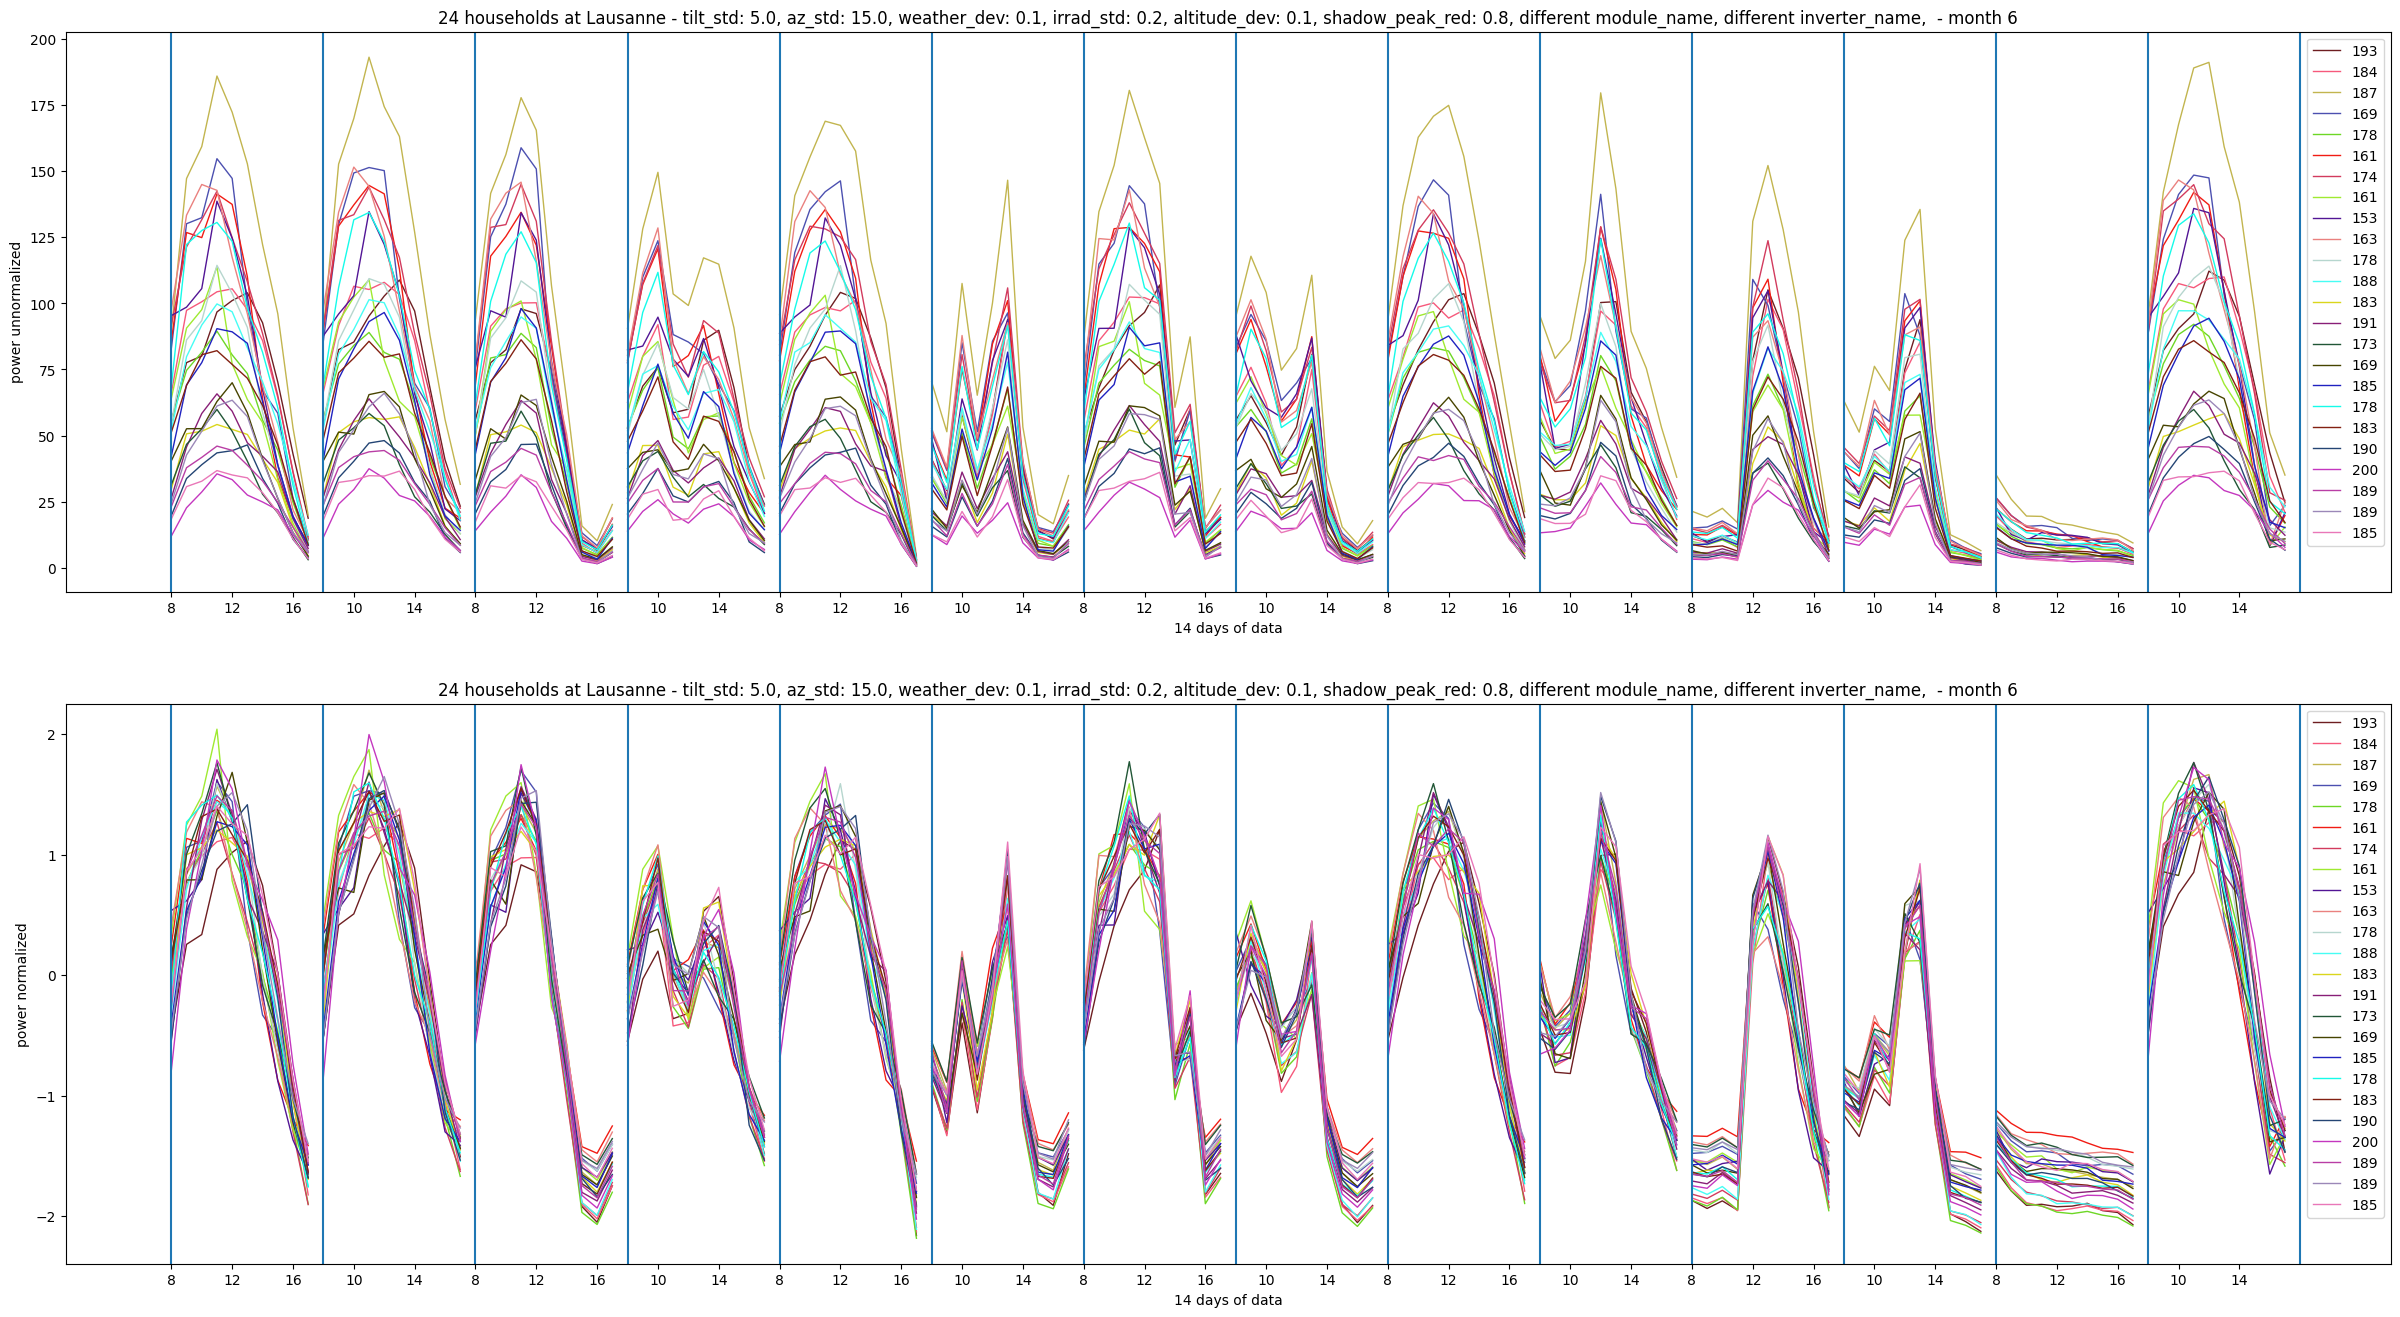

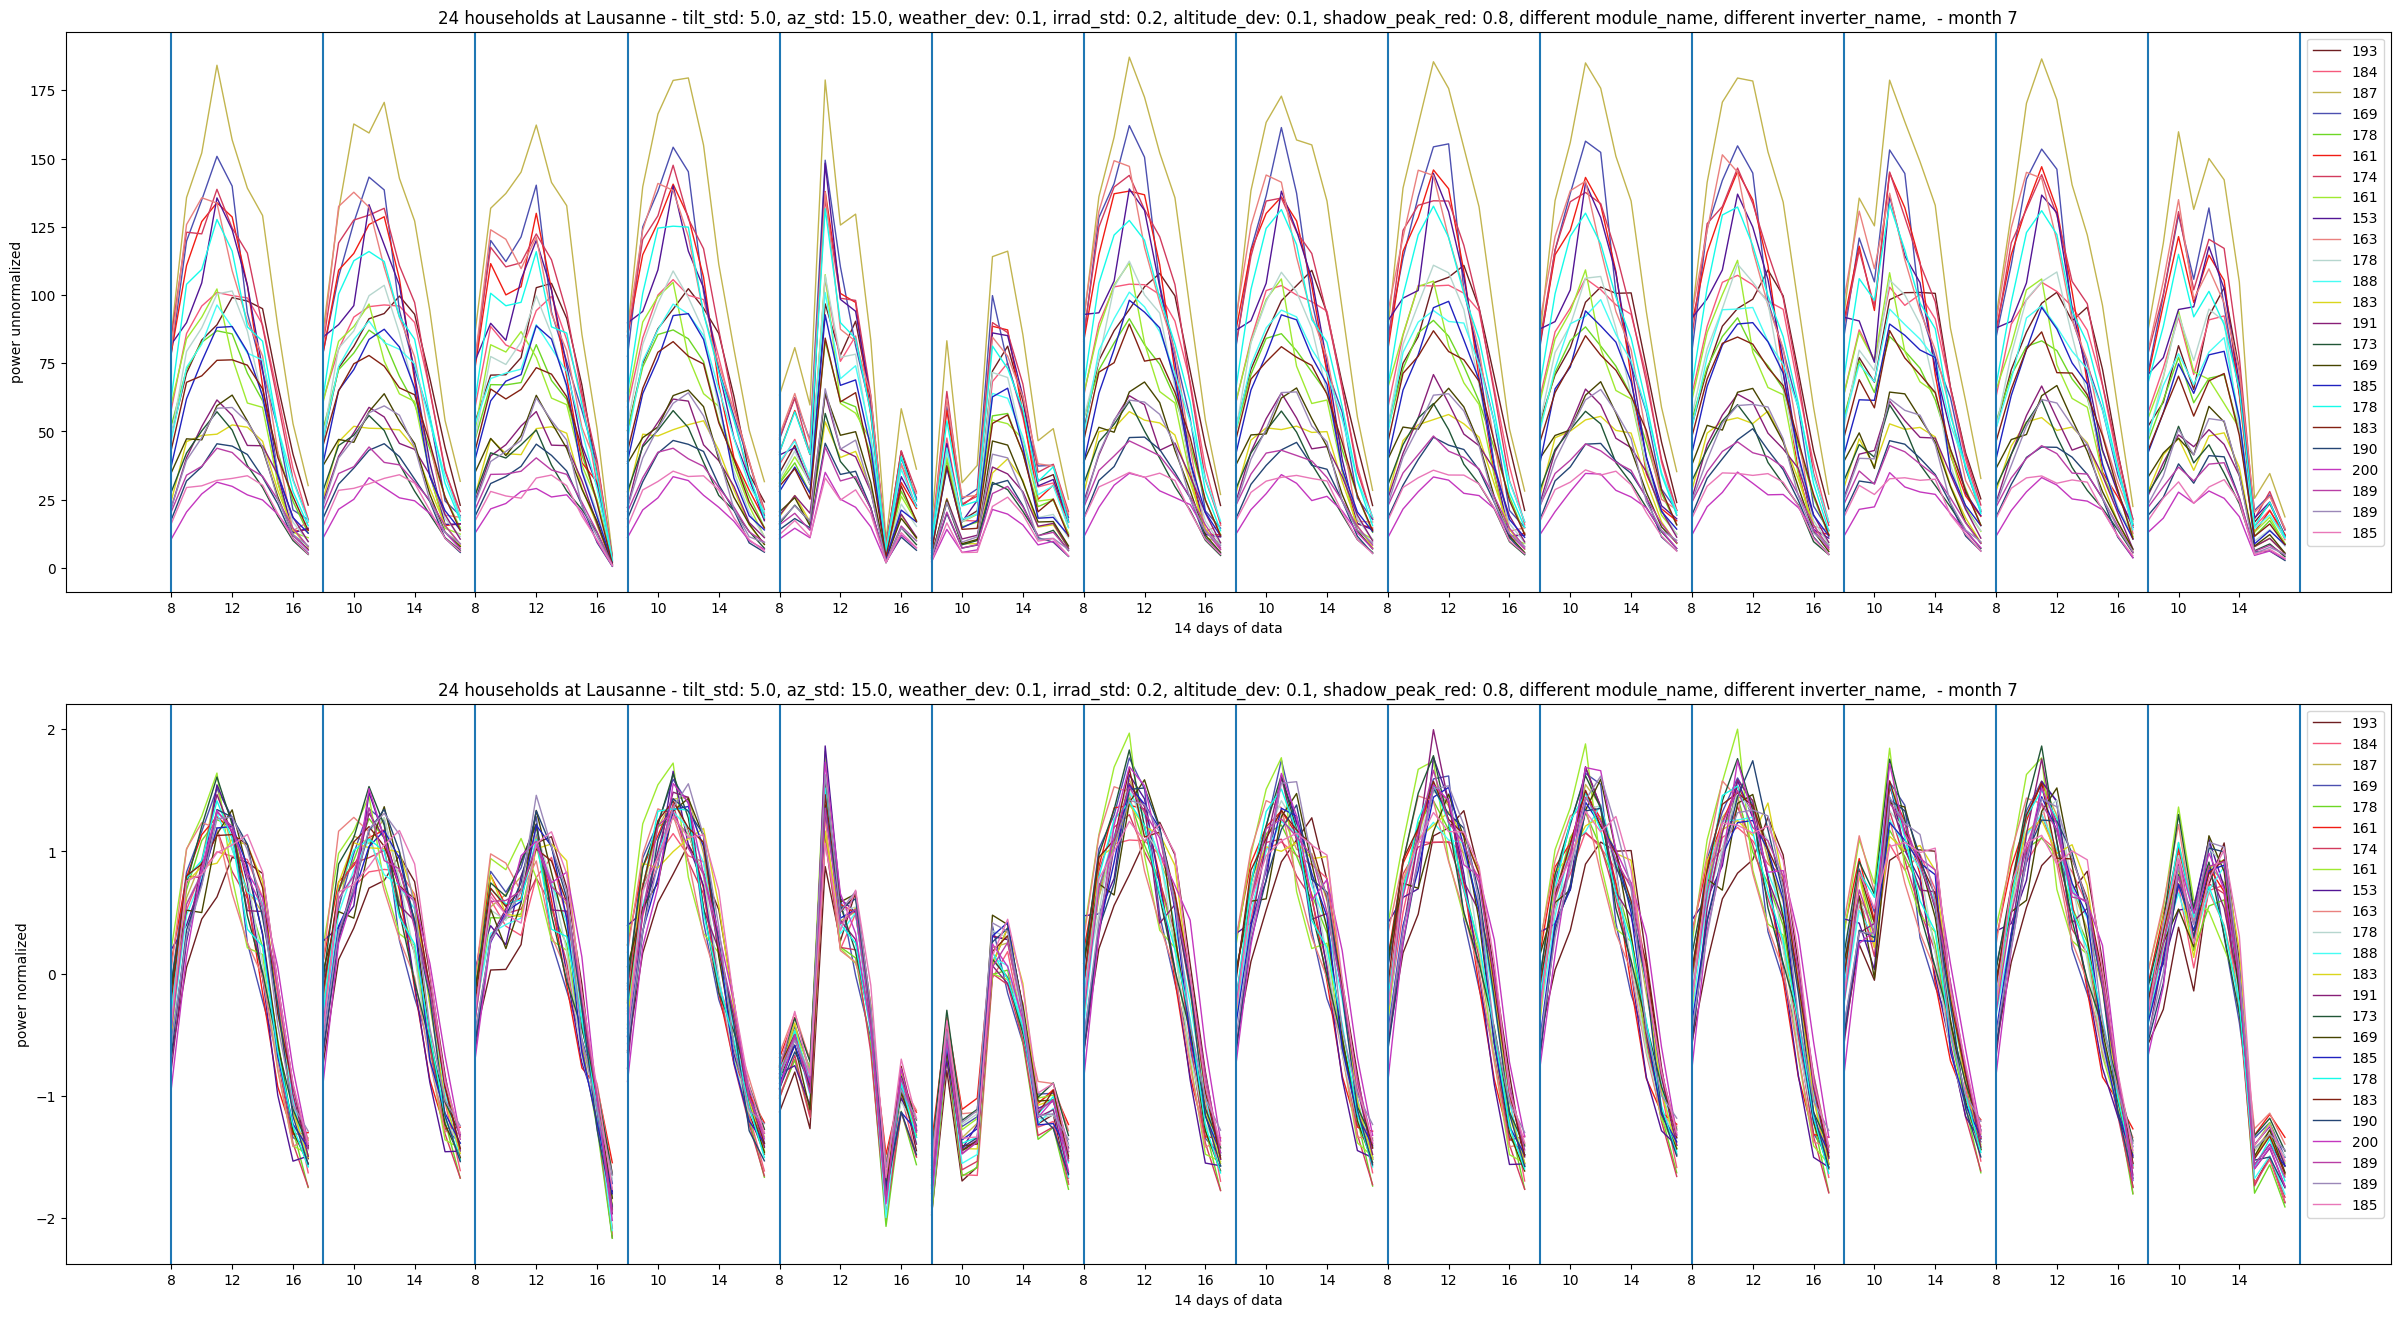

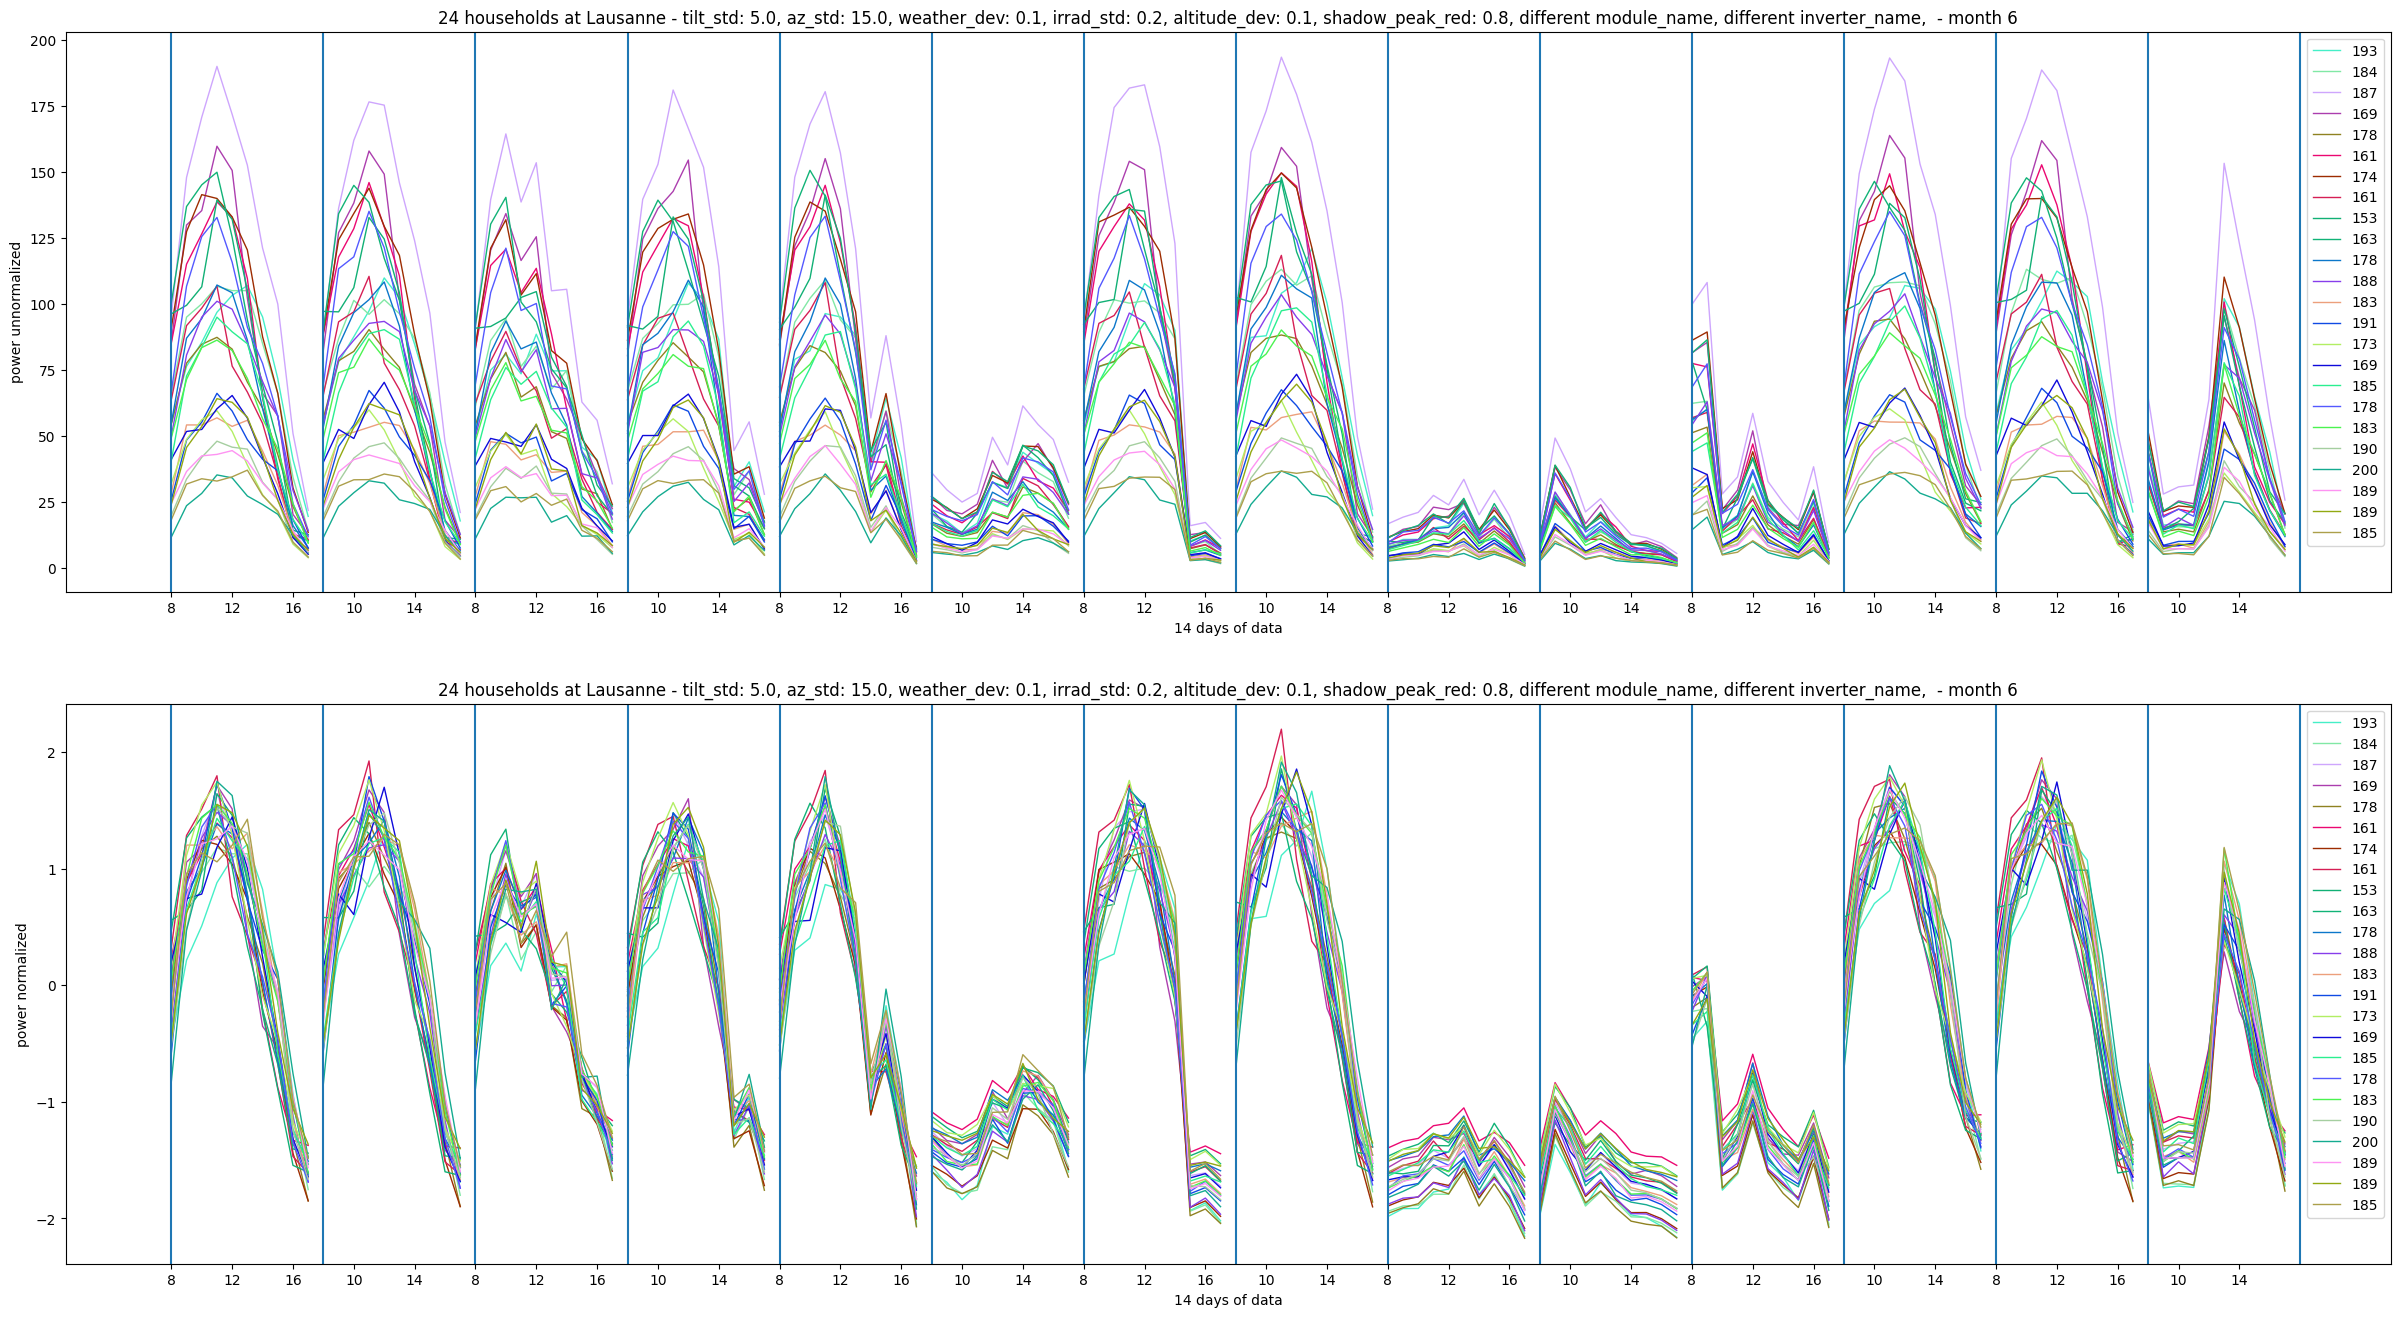

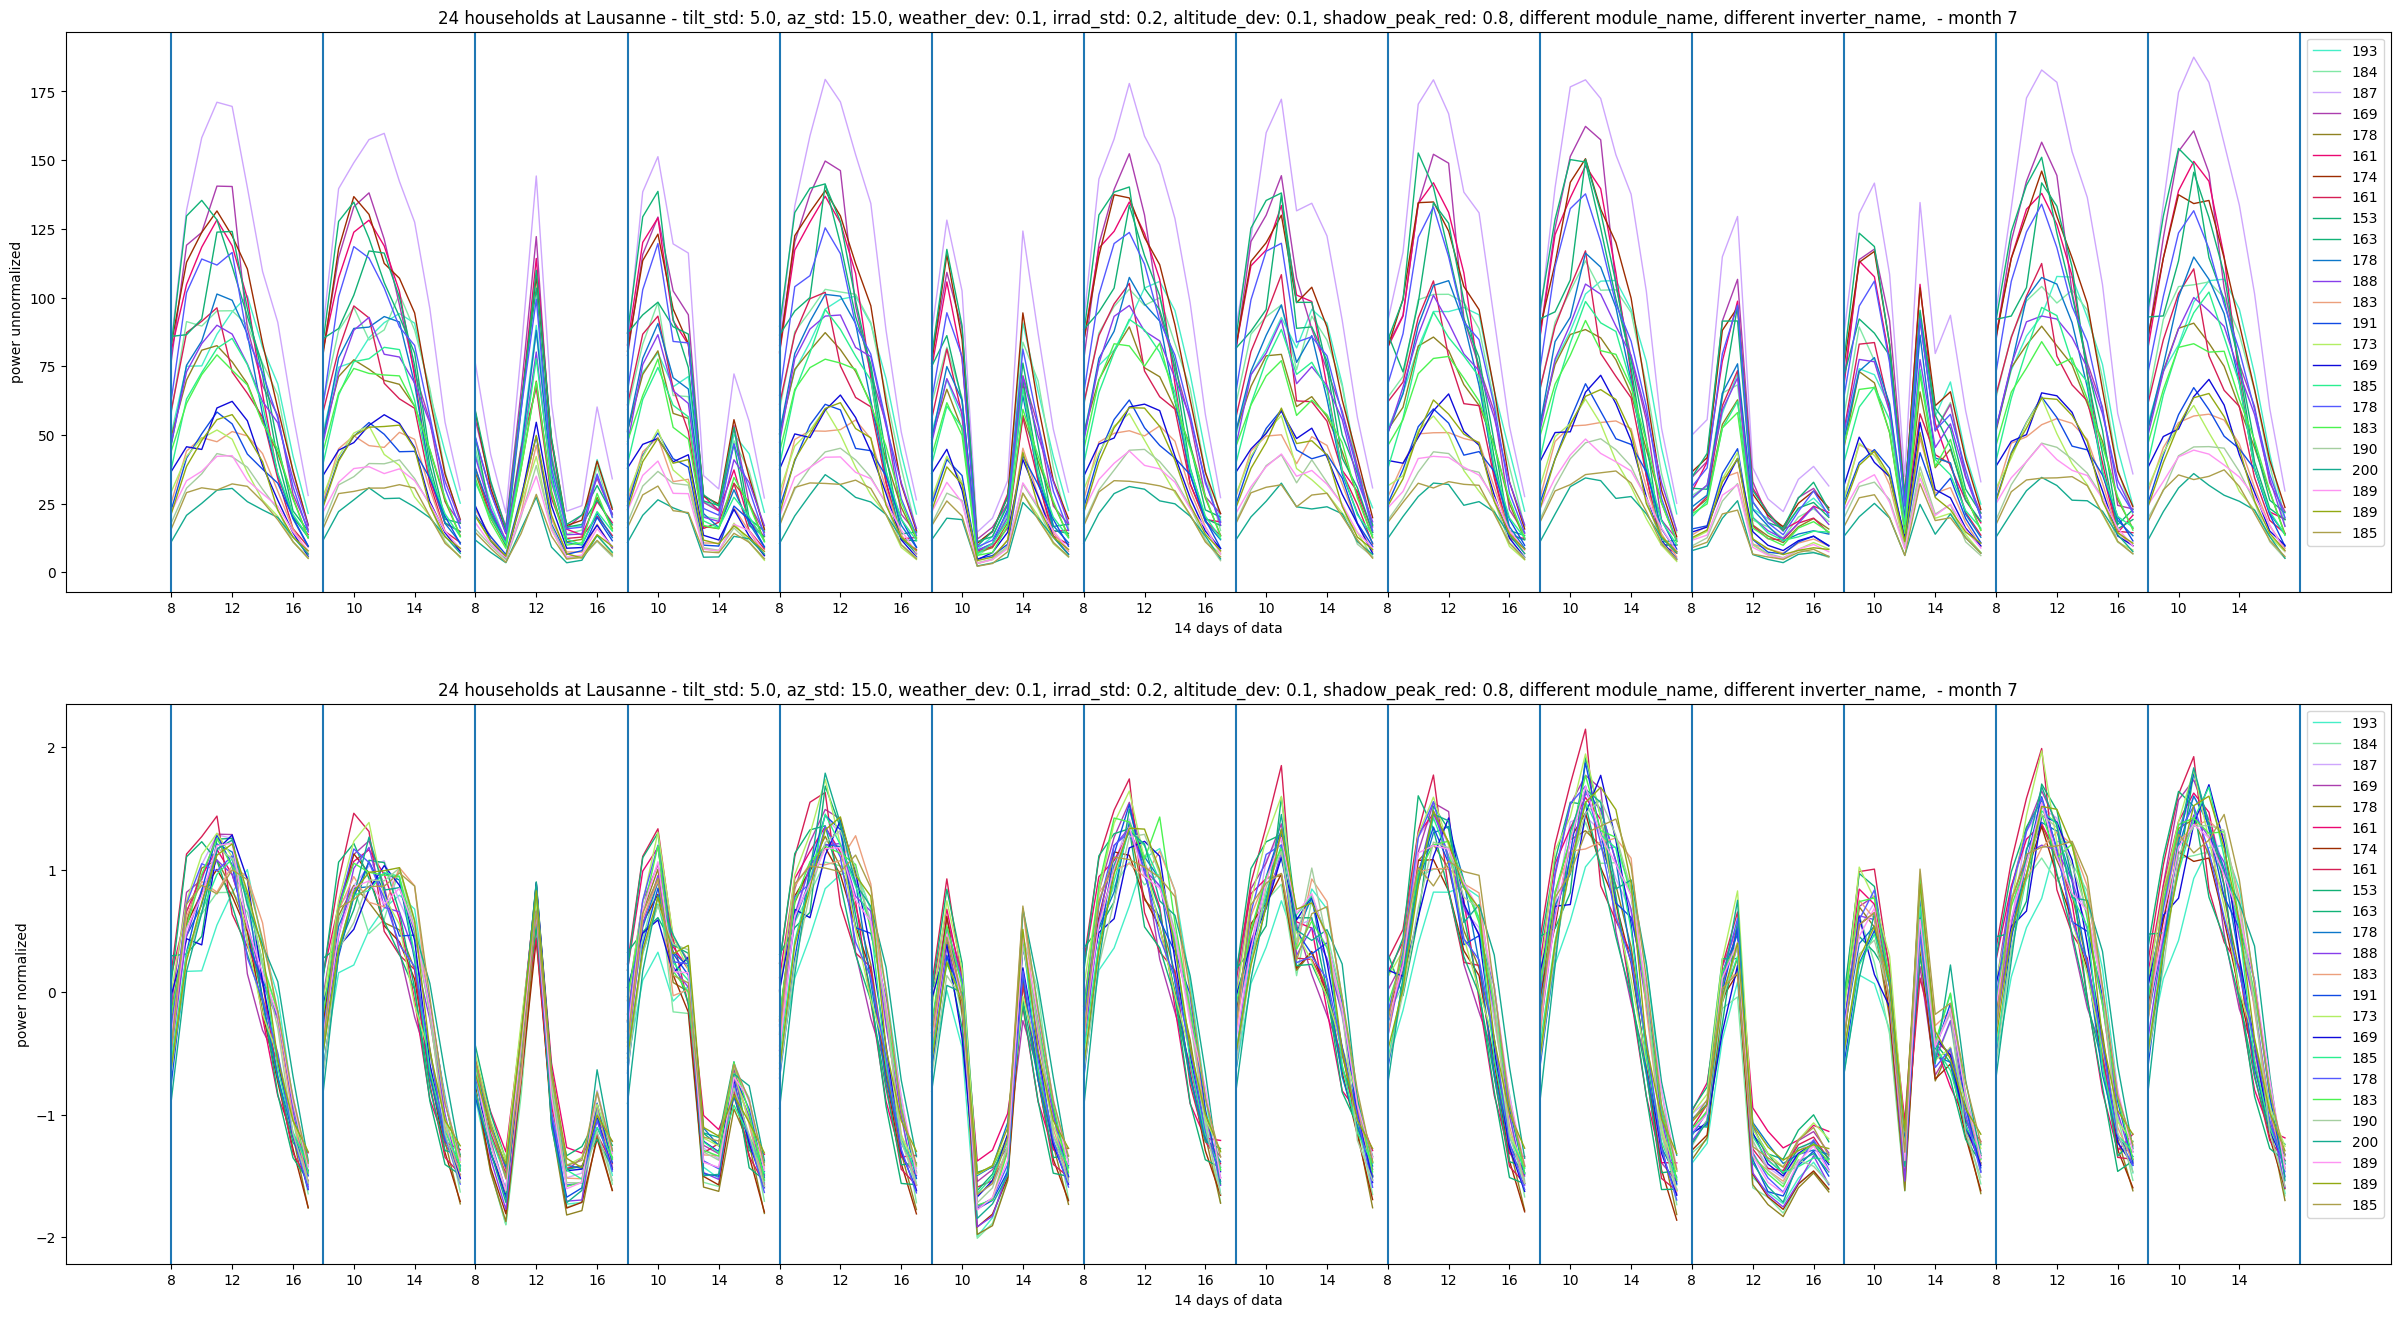

In [66]:
visualize_env(env_dict, num_days=14, year=2018, scenario_name=None)
visualize_env(env_dict, num_days=14, year=2019, scenario_name=None)

#Label the graphs to know the azimuth angle and the tilt angle

### Normalization
* For each client, we normalize both the features and the output.
* Normalization is done for both training and validation dataset using the mean and std of the "training data".
* Thus, all features and the output in the training data will have a zero mean and std of one. 
* In the validation set, the mean and std would not be exactly 0 and 1, but rather close to these values.

In [100]:
from utils_pv import normalize_data_tup

# normalizing the data with 150 training samples
scenario_name = 'sml'
clients_data = env_dict['train_scenarios'][scenario_name]['clients_data']
clients_data_nrm = [None]*len(clients_data)
for client_num in np.arange(env_dict['num_clients']):
    clients_data_nrm[client_num], _, _ = normalize_data_tup(clients_data[client_num])


In [110]:
len(clients_data_nrm[1])

4

### Ridge regression
With automatic penalty tuning

Evaluation metrics:
* root mean squared error (RMSE): positive value, a lower score is preferred
* adjusted r squared: between 0 and 1, closer to 1 is better


Notes on evaluation metrics: 
* calculate both measures on training and validation data. if training score is not good, the model is under-fitting, not trained well, or over-regularized. if the validation and training scores are far, the model is over-fitting.
* the metrics are calculated on the normalized data. This makes interpreting the results easier: if the model always predicts 0, RMSE train is 1 and RMSE valid is close to 1.

In [5]:
from model_training.search_models import RidgeWrapper

# get normalized training and validation data
client_num = 0  # fit for the house number 0
x_train_nrm, y_train_nrm, x_valid_nrm, y_valid_nrm = clients_data_nrm[client_num]

# fit Ridge regression with grid search over penalty
ridge_wrapper = RidgeWrapper(alphas=np.logspace(-6,2,80)) # penalty weights to test
ridge_wrapper.fit(x_train_nrm, y_train_nrm)

# evaluate on training data
y_train_pred = ridge_wrapper.predict(x_train_nrm).reshape(y_train_nrm.shape)
rmse_train = np.mean((y_train_pred-y_train_nrm)**2)**0.5
adj_r2_train = adj_r2_scorer(ridge_wrapper, x_train_nrm, y_train_nrm)

# evaluate on validation data
y_valid_pred = ridge_wrapper.predict(x_valid_nrm).reshape(y_valid_nrm.shape)
rmse_valid = np.mean((y_valid_pred-y_valid_nrm)**2)**0.5
adj_r2_valid = adj_r2_scorer(ridge_wrapper, x_valid_nrm, y_valid_nrm)

msg = 'Ridge regression for client {:2.0f}:'.format(client_num)
msg += '\nbest results obtained by penalty factor = ' + str(ridge_wrapper.alpha)
msg += '\nRMSE train = {:1.4f}, RMSE valid = {:1.4f}'.format(rmse_train, rmse_valid)
msg += '\nAdj R2 train = {:1.4f}, Adj R2 valid = {:1.4f}'.format(adj_r2_train, adj_r2_valid)
print(msg)


Ridge regression for client  0:
best results obtained by penalty factor = 1.0
RMSE train = 0.3430, RMSE valid = 0.5234
Adj R2 train = 0.8620, Adj R2 valid = 0.7057


### More Complex Models
* try using bigger datasets, e.g. '1y' or '5y'
* normalize the data before fitting the model
* tune hyper-parameters, e.g., penalty, NN depth, etc., with cross validation